# Probabilistic Reserves Estimation (Monte Carlo Simulation)
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Probabilistic Simulation and Cash Flow

## 1. Introduction
In reservoir engineering, calculating volumes deterministically (using single average values) is risky because subsurface parameters vary significantly.

This notebook demonstrates how to use **Monte Carlo Simulation** to calculate **Hydrocarbon Pore Volume (HCPV)**. Instead of multiplying single averages, we will multiply **probability distributions** to generate a range of possible outcomes.

**The Equation:**
$$HCPV = A \times h \times \phi \times S_o$$

**The Goal:**
Run **10,000 iterations** to determine:
* **P90**: 90% probability that the actual volume is at least this amount (Conservative).
* **P50**: 50% probability (Best Estimate).
* **P10**: 10% probability (Optimistic).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Reproducibility
np.random.seed(42)

## 2. Load and Analyze Input Data
We will load offset well data to understand the statistical properties (Mean, Standard Deviation) of our reservoir parameters. This data informs the distributions we generate later.

In [3]:
# Load the data
df = pd.read_csv('reservoir_data.csv')

# Display summary statistics to help us define our simulation parameters
print("Summary Statistics of Input Data:")
display(df.describe())

Summary Statistics of Input Data:


,Area_Estimate_Acres,Net_Pay_ft,Porosity,So
count,8.000000,8.000000,8.00000,8.000000
mean,249.125000,45.250000,0.19875,0.745000
std,11.166756,2.976575,0.02031,0.034641
min,230.000000,41.500000,0.17000,0.700000
25%,243.750000,43.100000,0.18750,0.717500
50%,249.000000,44.600000,0.19500,0.745000
75%,256.250000,47.150000,0.21250,0.765000
max,265.000000,50.100000,0.23000,0.800000


## 3. Define Simulation Parameters
Based on the data above and geological knowledge, we define the parameters for our Monte Carlo simulation.

* **Iterations:** 10,000 runs.
* **Area ($A$):** Modeled as a **Triangular Distribution**. We use the min, max, and mean from our data to define the bounds.
* **Thickness ($h$):** Modeled as a **Normal Distribution** using the mean and std dev from the well logs.
* **Porosity ($\phi$):** Modeled as a **Normal Distribution**.
* **Saturation ($S_o$):** Modeled as a **Uniform Distribution** between a defined Min and Max to capture higher uncertainty.

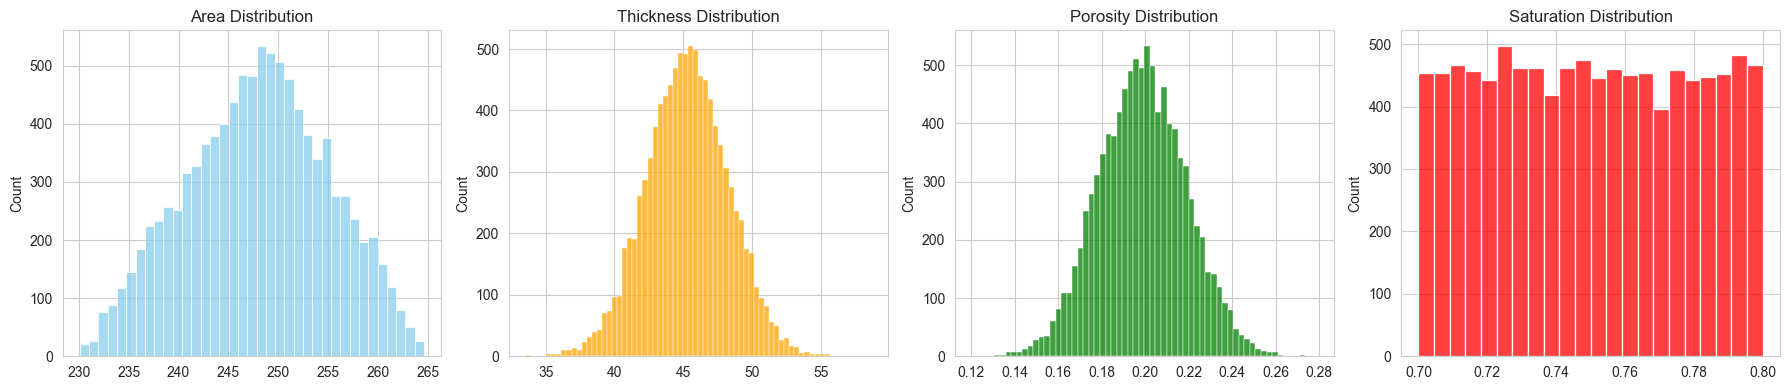

In [4]:
# Simulation Settings
n_iterations = 10000

# 1. Area (Triangular: min, mode, max)
# We estimate the mode slightly higher than the mean for this example
a_min = df['Area_Estimate_Acres'].min()
a_max = df['Area_Estimate_Acres'].max()
a_mode = df['Area_Estimate_Acres'].mean()

area_dist = np.random.triangular(left=a_min, mode=a_mode, right=a_max, size=n_iterations)

# 2. Thickness (Normal: mean, std)
h_mean = df['Net_Pay_ft'].mean()
h_std = df['Net_Pay_ft'].std()

thickness_dist = np.random.normal(loc=h_mean, scale=h_std, size=n_iterations)

# 3. Porosity (Normal: mean, std)
phi_mean = df['Porosity'].mean()
phi_std = df['Porosity'].std()

porosity_dist = np.random.normal(loc=phi_mean, scale=phi_std, size=n_iterations)

# 4. Saturation (Uniform: min, max)
so_min = df['So'].min()
so_max = df['So'].max()

saturation_dist = np.random.uniform(low=so_min, high=so_max, size=n_iterations)

# Visualizing the input distributions
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
sns.histplot(area_dist, ax=axes[0], color='skyblue').set_title('Area Distribution')
sns.histplot(thickness_dist, ax=axes[1], color='orange').set_title('Thickness Distribution')
sns.histplot(porosity_dist, ax=axes[2], color='green').set_title('Porosity Distribution')
sns.histplot(saturation_dist, ax=axes[3], color='red').set_title('Saturation Distribution')
plt.tight_layout()
plt.show()

## 4. Run Monte Carlo Simulation
We perform the calculation using **NumPy vectorization**. This multiplies the arrays element-wise, effectively running 10,000 calculations simultaneously without a slow `for` loop.

$$Result = Area \times Thickness \times Porosity \times Saturation$$

In [5]:
# Calculate Reserves (Volumetric)
# Result is in Acre-ft (if we don't apply conversion factors)
# For this exercise, we assume the unit is generic "Reserves Units"
volumetric_reserves = area_dist * thickness_dist * porosity_dist * saturation_dist

# Handle negative values if any (Normal distribution theoretically can go negative)
volumetric_reserves = np.maximum(volumetric_reserves, 0)

print(f"First 5 Iteration Results: {volumetric_reserves[:5]}")

First 5 Iteration Results: [1402.46369611 1646.39871866 1503.496674   1450.5753588  1934.53979253]


## 5. Calculate P10, P50, P90 Estimates
We use `np.percentile` to extract the key probability metrics.
* **P90**: 90% chance estimates exceed this value.
* **P50**: Median value.
* **P10**: 10% chance estimates exceed this value.

In [6]:
# Calculate Percentiles
p90 = np.percentile(volumetric_reserves, 10) # 10th percentile of data = 90% probability of exceeding
p50 = np.percentile(volumetric_reserves, 50)
p10 = np.percentile(volumetric_reserves, 90) # 90th percentile of data = 10% probability of exceeding

print(f"P90 (Proven): {p90:.2f}")
print(f"P50 (Probable): {p50:.2f}")
print(f"P10 (Possible): {p10:.2f}")

P90 (Proven): 1396.95
P50 (Probable): 1666.54
P10 (Possible): 1958.90


## 6. Visualization
We plot the **Frequency Histogram** and the **Cumulative Distribution Function (CDF)** to visualize the range of uncertainty. The vertical lines represent our P90, P50, and P10 values.

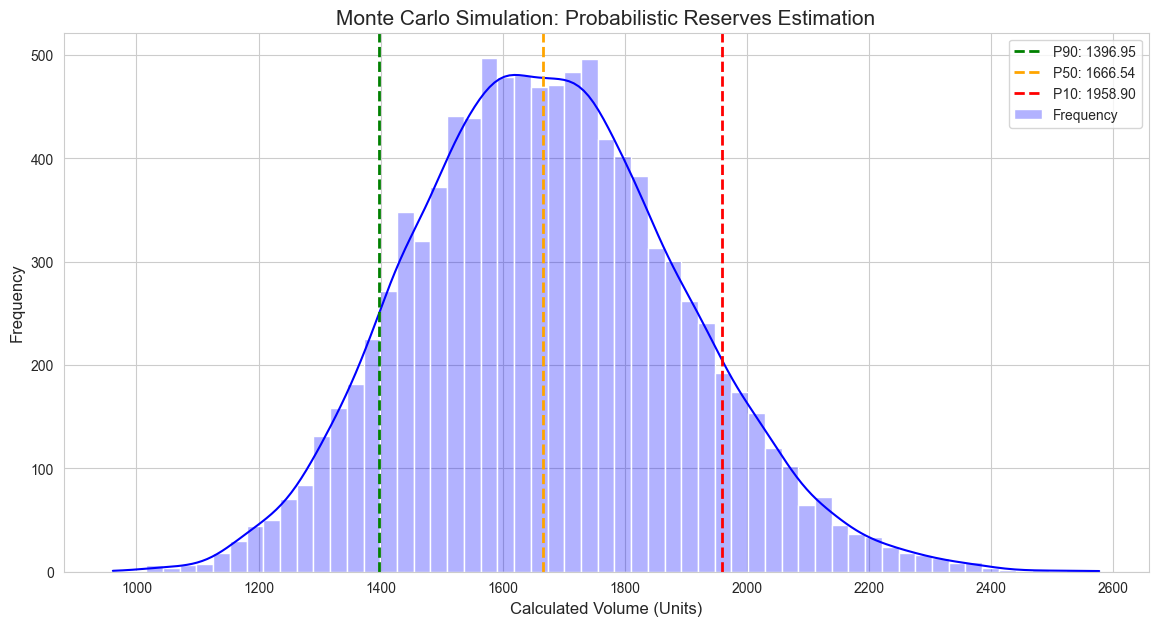

In [7]:
plt.figure(figsize=(14, 7))

# Plot Histogram
sns.histplot(volumetric_reserves, kde=True, color='blue', alpha=0.3, label='Frequency')

# Plot P-Values
plt.axvline(p90, color='green', linestyle='--', linewidth=2, label=f'P90: {p90:.2f}')
plt.axvline(p50, color='orange', linestyle='--', linewidth=2, label=f'P50: {p50:.2f}')
plt.axvline(p10, color='red', linestyle='--', linewidth=2, label=f'P10: {p10:.2f}')

plt.title('Monte Carlo Simulation: Probabilistic Reserves Estimation', fontsize=15)
plt.xlabel('Calculated Volume (Units)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()